In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pyttsx3
import os
import scipy.io.wavfile
import scipy.signal
import scipy.spatial.distance
import librosa
import librosa.display
import copy

In [2]:
WORDS = [
    "time", "prepare", "solution", "make", "mistake", "no", "the", "probable", "long", "lecture",
    "method", "disaster", "fail", "work", "advice", "idea", "succeed", "easy", "is", "for", "give",
    "to" # Added word "to" which is not in assingment list but appears in the audio
]

WORDS_DIR = "words/"

# the work easy the time long to prepare the solution
SOLUTION = ["the", "work", "easy", "the", "time", "long", "to", "prepare", "the", "solution"]

In [3]:
### Generate words WAV files

if not os.path.exists(WORDS_DIR):
    os.mkdir(WORDS_DIR)
    
engine = pyttsx3.init()
for word in WORDS:
    # skip existing
    if os.path.exists(os.path.join(WORDS_DIR, "%s.wav" % word)):
        continue
    engine.save_to_file(word, os.path.join(WORDS_DIR, "%s.wav" % word))
engine.runAndWait()

In [4]:
### Helper functions

def trim_signal(s1, trim_threshold=10):
    s1[(-trim_threshold < s1) & (s1 < trim_threshold)] = 0
    
    fhalf = s1[:s1.size//2]
    start_trimmed = fhalf[fhalf == 0].size
    shalf = s1[s1.size//2:]
    end_trimmed = shalf[shalf == 0].size
    
    ts1 = np.trim_zeros(s1)
    return ts1, start_trimmed, end_trimmed
    
def trim_pad_pair(s1, s2, trim_threshold=10):
    ts1, _, _ = trim_signal(s1)
    ts2, _, _ = trim_signal(s2)
    msize = max(ts1.size, ts2.size)
    psize = (msize // 1000 + 1)*1000
    ps1 = np.pad(ts1, (0, psize - ts1.size))
    ps2 = np.pad(ts2, (0, psize - ts2.size))
    
    return ps1, ps2

def load_file(filename):
    fs, s = scipy.io.wavfile.read(filename)
    s, _, _ = trim_signal(s)
    return fs, s.astype(np.float64)

def load_word(word):
    filename = os.path.join(WORDS_DIR, "%s.wav" % word)
    return load_file(filename)

def write_wav(data, filename, rate=22050): 
    scipy.io.wavfile.write(filename, rate, data)
    
def split_data(data, window_size=1000, threshold=1600):
    data = copy.deepcopy(data)
    
    base = 0
    is_voice = False
    n_empty = 0
    
    msize = data.size
    psize = (msize // window_size + 1)*window_size
    data = np.pad(data, (0, psize - data.size))

    parts = []
    regions = []

    for i, window in enumerate(np.split(data, data.size / window_size)):
        #_sum = np.sum(np.abs(window))
        _max = np.max(np.abs(window))
        if n_empty > 1 and is_voice:
            part = data[base:(i+1)*window_size]
            part, st, et = trim_signal(part)
            parts.append(part)
            
            regions.append( (base+st, base+st+part.size) )

            base = (i+1)*window_size
            is_voice = False
            n_empty = 0
        elif _max >= threshold and not is_voice:
            is_voice = True
        elif _max < threshold and is_voice:
            n_empty += 1
            
    if not parts:
        return [data], None
    return parts, regions

In [5]:
### LOAD data

data = np.loadtxt("Signal1.txt")
#data = data[:data.size - data.size%1000]

awords = []
for word in WORDS:
    sr, X = load_word(word)
    awords.append( (word, sr, X) )
    
### Split data
parts, regions = split_data(data)

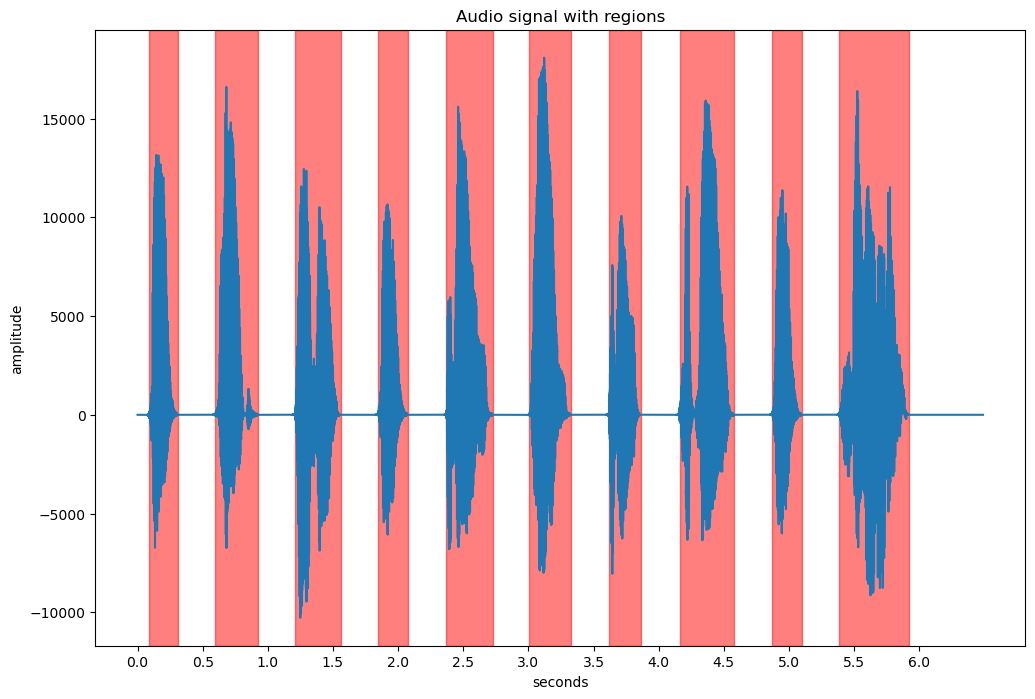

In [6]:
ymin = np.min(data)
ymax = np.max(data)

plt.figure(figsize=(12, 8))

plt.plot(data)

#colors = plt.cm.get_cmap("inferno", len(regions)).colors
for i, (start, end) in enumerate(regions):
    #color = colors[i]
    color = "red"
    plt.axvspan(start, end, color=color, alpha=0.5)
    
#plt.xticks(np.arange(0, len(data), 22050), np.round(np.arange(0, len(data), 22050)/22050, 1))
ticks = np.arange(0, len(data), 22050/2)
plt.xticks(ticks, np.round(ticks/22050, 2))

plt.xlabel("seconds")
plt.ylabel("amplitude")
plt.title("Audio signal with regions")

plt.show()

In [7]:
correct = 0
for answer, Y in zip(SOLUTION, parts):
    similarities = []
    for (word, sr, X) in awords:
        #sr, X = load_word(word)
        pX, pY = trim_pad_pair(X, Y)
        #X *= np.hamming(X.size)

        ###f, t, Sxx1 = scipy.signal.spectrogram(pX, sr)
        ###f, t, Sxx2 = scipy.signal.spectrogram(pY, sr)
        ###dist_spec = scipy.spatial.distance.cosine(Sxx1.flatten(), Sxx2.flatten())

        #dist, cost, acc_cost, path = dtw(pX, pY, dist=lambda x, y: np.linalg.norm(x - y, ord=1))
        #similarity = dist
        
        # Mel spectrum
        sX = librosa.feature.melspectrogram(y=pX, sr=sr, n_fft=2048)
        # Mel cepstrum coefs
        mfccsX = librosa.feature.mfcc(S=librosa.power_to_db(sX))
        sY = librosa.feature.melspectrogram(y=pY, sr=sr, n_fft=2048)
        mfccsY = librosa.feature.mfcc(S=librosa.power_to_db(sY))
        #dist_mfccs = scipy.spatial.distance.cosine(mfccsX.flatten(), mfccsY.flatten())
        (dist_mfccs, _, _) = scipy.spatial.distance.directed_hausdorff(mfccsX, mfccsY)
        #dist_mfccs = np.sum(scipy.spatial.distance.cdist(mfccsX, mfccsY))
        
        
        ###fftX = np.fft.fft(pX)
        ###fftY = np.fft.fft(pY)
        ###dist_fft = scipy.spatial.distance.cosine(fftX,  fftY)
        
        #cqtX = librosa.cqt(pX)
        #cqtY = librosa.cqt(pY)
        #cqtX = librosa.feature.chroma_cqt(y=pX, hop_length=256)
        #cqtY = librosa.feature.chroma_cqt(y=pY, hop_length=256)
        #dist_cqt = scipy.spatial.distance.cosine(cqtX.flatten(), cqtY.flatten())
        
        #stftX = np.abs(librosa.stft(pX, n_fft=512))
        #stftX = librosa.amplitude_to_db(stftX, ref=np.max)
        #stftY = np.abs(librosa.stft(pY, n_fft=512))
        #stftY = librosa.amplitude_to_db(stftY, ref=np.max)
        #dist_stft = scipy.spatial.distance.cosine(stftX.flatten(), stftY.flatten())
        
        # Fourier tempogram
        #tX = librosa.feature.fourier_tempogram(y=pX)
        #tY = librosa.feature.fourier_tempogram(y=pY)
        #dist_ft = scipy.spatial.distance.cosine(tX.flatten(), tY.flatten())
        #(dist_ft, _, _) = scipy.spatial.distance.directed_hausdorff(tX, tY)
        
        # Spectral centroid
        scX = librosa.feature.spectral_centroid(y=pX, n_fft=2048)
        scY = librosa.feature.spectral_centroid(y=pY, n_fft=2048)
        #dist_sc = scipy.spatial.distance.cosine(scX.flatten(), scY.flatten())
        (dist_sc, _, _) = scipy.spatial.distance.directed_hausdorff(scX, scY)
        #dist_sc = np.sum(scipy.spatial.distance.cdist(mfccsX, mfccsY))
        
        #pfX = librosa.feature.poly_features(y=pX, n_fft=2048)
        #pfY = librosa.feature.poly_features(y=pY, n_fft=2048)
        #dist_pf = scipy.spatial.distance.cosine(pfX.flatten(), pfY.flatten())
        #(dist_pf, _, _) = scipy.spatial.distance.directed_hausdorff(pfX, pfY)

        #similarity = dist_spec + dist_mfccs + dist_fft + dist_cqt + dist_stft
        #similarity = dist_mfccs + dist_ft * 0.25 + dist_cqt * 0.25
        similarity = dist_mfccs + dist_sc * 0.25

        similarities.append( (word, similarity) )
    
    guess = sorted(similarities, key=lambda x: x[1])[0:3]
    # Convert to likelihood
    #guess = [(x[0], np.round(1-x[1], 3)) for x in guess]
    guess = [(x[0], np.round(x[1], 2)) for x in guess]
    #guess = [x[0] for x in guess]
    #print(answer, [x[0] for x in guess])
    print(answer, *guess)
    if answer == guess[0][0]:
        correct += 1
        
correct_percentage = correct / len(parts) * 100
print("Correct: %s/%s (%s%%)" % (correct, len(parts), correct_percentage))

the ('the', 849.18) ('long', 1259.56) ('no', 1286.97)
work ('work', 934.09) ('make', 1097.47) ('long', 1643.03)
easy ('easy', 969.31) ('long', 1188.79) ('no', 1379.76)
the ('the', 1213.8) ('long', 1218.95) ('no', 1239.23)
time ('for', 800.51) ('fail', 816.83) ('time', 865.69)
long ('long', 961.67) ('no', 1063.27) ('the', 1615.73)
to ('to', 1049.84) ('the', 1171.34) ('for', 1220.0)
prepare ('probable', 968.79) ('prepare', 1093.65) ('long', 1430.63)
the ('the', 1218.15) ('no', 1225.33) ('long', 1258.34)
solution ('solution', 1762.02) ('disaster', 2606.38) ('probable', 2692.28)
Correct: 8/10 (80.0%)


# Without splitting

In [8]:
#tdata = data[10000:22000]
tdata = data
window_ratio = 1/4

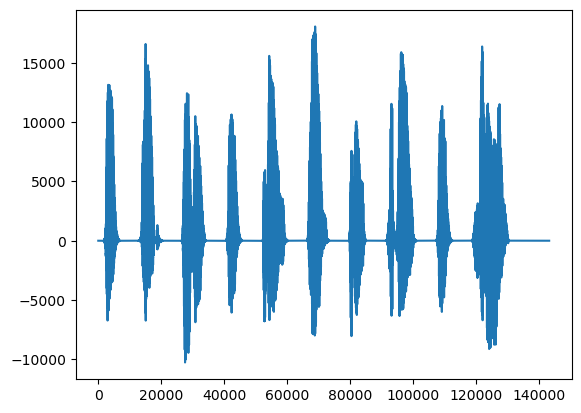

In [9]:
plt.plot(tdata)

In [10]:
best = None
min_dist = np.inf
threshold = 0.045

detected = []

for (word, sr, X) in awords:

    #print(word, X.size)
    base = 0
    window_size = int(X.size * window_ratio)

    while tdata[base:].size >= X.size:
        end = base + X.size
        Y = tdata[base:end]

        sX = librosa.feature.melspectrogram(y=X, sr=sr, n_fft=2048)
        # Mel cepstrum coefs
        mfccsX = librosa.feature.mfcc(S=librosa.power_to_db(sX))
        sY = librosa.feature.melspectrogram(y=Y, sr=sr, n_fft=2048)
        mfccsY = librosa.feature.mfcc(S=librosa.power_to_db(sY))
        dist = scipy.spatial.distance.cosine(mfccsX.flatten(), mfccsY.flatten())

        #print(base, end, dist)

        #if dist < min_dist:
        #    best = (word, base, end)
        #    min_dist = dist
        
        if dist < threshold:
            detected.append( (word, base, end, dist) )
            
        base += window_size
        
#print(best, min_dist)
for t in detected:
    print(t)

('time', 1746, 8731, 0.04200161394388746)
('time', 13968, 20953, 0.03136365804286734)
('time', 26190, 33175, 0.04429648794343077)
('time', 27936, 34921, 0.037151351877675265)
('time', 40158, 47143, 0.03951009549913387)
('time', 52380, 59365, 0.01642303315765825)
('time', 54126, 61111, 0.031885003005640344)
('time', 66348, 73333, 0.02118488158962939)
('time', 68094, 75079, 0.0399512292525489)
('time', 78570, 85555, 0.038628983925259375)
('time', 80316, 87301, 0.04070694745112691)
('time', 92538, 99523, 0.038605423041974896)
('time', 94284, 101269, 0.02632706178945099)
('time', 106506, 113491, 0.042135835337651084)
('time', 118728, 125713, 0.0405972536491751)
('time', 120474, 127459, 0.03646018973044096)
('time', 122220, 129205, 0.03474355317521782)
('time', 123966, 130951, 0.03327837867232053)
('prepare', 12534, 20890, 0.04183704338483907)
('prepare', 25068, 33424, 0.04096506668643429)
('prepare', 50136, 58492, 0.03856530188727458)
('prepare', 52225, 60581, 0.036461164382357025)
('prepa

# Test data

In [11]:
data = np.loadtxt("Signal2.txt")
parts, regions = split_data(data, threshold=15000)

len(regions)

4

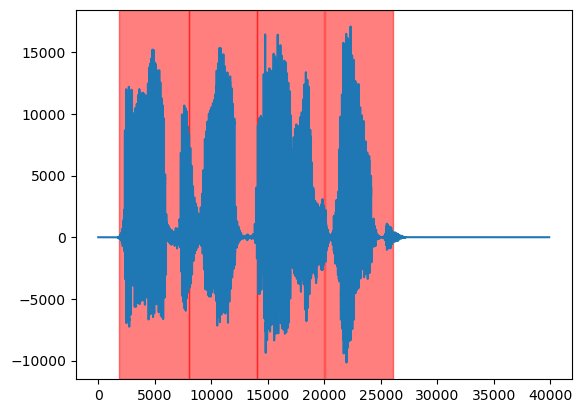

In [12]:
ymin = np.min(data)
ymax = np.max(data)

plt.plot(data)

#colors = plt.cm.get_cmap("inferno", len(regions)).colors
for i, (start, end) in enumerate(regions):
    #color = colors[i]
    color = "red"
    plt.axvspan(start, end, color=color, alpha=0.5)

In [13]:
for Y in parts:
    similarities = []
    for (word, sr, X) in awords:
        #sr, X = load_word(word)
        pX, pY = trim_pad_pair(X, Y)
        #X *= np.hamming(X.size)

        ###f, t, Sxx1 = scipy.signal.spectrogram(pX, sr)
        ###f, t, Sxx2 = scipy.signal.spectrogram(pY, sr)
        ###dist_spec = scipy.spatial.distance.cosine(Sxx1.flatten(), Sxx2.flatten())

        #dist, cost, acc_cost, path = dtw(pX, pY, dist=lambda x, y: np.linalg.norm(x - y, ord=1))
        #similarity = dist
        
        # Mel spectrum
        sX = librosa.feature.melspectrogram(y=pX, sr=sr, n_fft=2048)
        # Mel cepstrum coefs
        mfccsX = librosa.feature.mfcc(S=librosa.power_to_db(sX))
        sY = librosa.feature.melspectrogram(y=pY, sr=sr, n_fft=2048)
        mfccsY = librosa.feature.mfcc(S=librosa.power_to_db(sY))
        #dist_mfccs = scipy.spatial.distance.cosine(mfccsX.flatten(), mfccsY.flatten())
        (dist_mfccs, _, _) = scipy.spatial.distance.directed_hausdorff(mfccsX, mfccsY)
        #dist_mfccs = np.sum(scipy.spatial.distance.cdist(mfccsX, mfccsY))
        
        
        ###fftX = np.fft.fft(pX)
        ###fftY = np.fft.fft(pY)
        ###dist_fft = scipy.spatial.distance.cosine(fftX,  fftY)
        
        #cqtX = librosa.cqt(pX)
        #cqtY = librosa.cqt(pY)
        #cqtX = librosa.feature.chroma_cqt(y=pX, hop_length=256)
        #cqtY = librosa.feature.chroma_cqt(y=pY, hop_length=256)
        #dist_cqt = scipy.spatial.distance.cosine(cqtX.flatten(), cqtY.flatten())
        
        #stftX = np.abs(librosa.stft(pX, n_fft=512))
        #stftX = librosa.amplitude_to_db(stftX, ref=np.max)
        #stftY = np.abs(librosa.stft(pY, n_fft=512))
        #stftY = librosa.amplitude_to_db(stftY, ref=np.max)
        #dist_stft = scipy.spatial.distance.cosine(stftX.flatten(), stftY.flatten())
        
        # Fourier tempogram
        #tX = librosa.feature.fourier_tempogram(y=pX)
        #tY = librosa.feature.fourier_tempogram(y=pY)
        #dist_ft = scipy.spatial.distance.cosine(tX.flatten(), tY.flatten())
        #(dist_ft, _, _) = scipy.spatial.distance.directed_hausdorff(tX, tY)
        
        scX = librosa.feature.spectral_centroid(y=pX, n_fft=2048)
        scY = librosa.feature.spectral_centroid(y=pY, n_fft=2048)
        #dist_sc = scipy.spatial.distance.cosine(scX.flatten(), scY.flatten())
        (dist_sc, _, _) = scipy.spatial.distance.directed_hausdorff(scX, scY)
        #dist_sc = np.sum(scipy.spatial.distance.cdist(mfccsX, mfccsY))
        
        #pfX = librosa.feature.poly_features(y=pX, n_fft=2048)
        #pfY = librosa.feature.poly_features(y=pY, n_fft=2048)
        #dist_pf = scipy.spatial.distance.cosine(pfX.flatten(), pfY.flatten())
        #(dist_pf, _, _) = scipy.spatial.distance.directed_hausdorff(pfX, pfY)

        #similarity = dist_spec + dist_mfccs + dist_fft + dist_cqt + dist_stft
        #similarity = dist_mfccs + dist_ft * 0.25 + dist_cqt * 0.25
        similarity = dist_mfccs + dist_sc * 0.25

        similarities.append( (word, similarity) )
    
    guess = sorted(similarities, key=lambda x: x[1])[0:3]
    # Convert to likelihood
    #guess = [(x[0], np.round(1-x[1], 3)) for x in guess]
    guess = [(x[0], np.round(x[1], 2)) for x in guess]
    #guess = [x[0] for x in guess]
    #print(answer, [x[0] for x in guess])
    print(*guess)

('no', 890.51) ('long', 916.48) ('work', 1288.38)
('work', 1019.4) ('no', 1080.22) ('make', 1138.67)
('make', 1513.01) ('work', 1536.62) ('give', 2257.57)
('for', 1434.6) ('time', 1563.91) ('fail', 1606.92)
